In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

In [5]:
# Load Image GPS Coordinates
# Create a DataFrame with image IDs and their corresponding GPS coordinates
streets = network 

image_data = {
    'image_id': np.linspace(0, len(panoids) - 1, len(panoids)),
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Perform Spatial Join
matched = gpd.sjoin_nearest(images_gdf, streets, how='left', distance_col='distance')

# Now 'matched' contains street information for each image
matched[['image_id', 'longitude', 'latitude', 'distance'][:5][0:2]]
matched_first_row = matched.iloc[[8]]

print(matched_first_row[['image_id', 'longitude', 'latitude', 'distance']])


   image_id  longitude   latitude  distance
8       8.0  -0.111446  51.510339  0.000574


c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [6]:
import geopandas as gpd
from shapely.geometry import LineString

def split_line(line, max_segment_length=50):
    # Calculate the number of segments
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    
    # Create a list to store the segments
    segments = []
    
    # Generate points along the line at each segment length
    for i in range(num_segments):
        start_point = line.interpolate(i * segment_length)
        end_point = line.interpolate(min((i + 1) * segment_length, line.length))
        segment = LineString([start_point, end_point])
        segments.append(segment)
    
    return segments

# Load the streets data
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Re-project to a suitable CRS if necessary
if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=28992)  # Use a projected CRS like EPSG:28992 for the Netherlands

# Calculate lengths
streets['length'] = streets.length

# Split lines longer than 100 meters
split_segments = []
for _, row in streets.iterrows():
    if row['length'] > 100:
        split_segments.extend(split_line(row['geometry'], max_segment_length=50))
    else:
        split_segments.append(row['geometry'])

# Create a new GeoDataFrame with the split segments
split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

# Optionally, calculate the new lengths
split_streets_gdf_max_L = split_streets_gdf_max.length

# Display the result
print(split_streets_gdf_max)


                                               geometry
0     LINESTRING (-224559.45 405323.931, -224588.869...
1     LINESTRING (-224588.869 405310.835, -224632.67...
2     LINESTRING (-224632.678 405322.537, -224676.53...
3     LINESTRING (-224713.082 405344.849, -224676.53...
4     LINESTRING (-224713.082 405344.849, -224736.85...
...                                                 ...
5807  LINESTRING (-224265.34 406775.406, -224232.712...
5808  LINESTRING (-224232.712 406769.725, -224197.67...
5809  LINESTRING (-224197.674 406755.318, -224161.70...
5810  LINESTRING (-224250.452 406784.135, -224247.72...
5811  LINESTRING (-224247.727 406782.858, -224182.29...

[5812 rows x 1 columns]


In [7]:
from shapely.geometry import LineString
from shapely.ops import linemerge

def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for _, row in streets_gdf.iterrows():
        line = row['geometry']
        line_length = line.length

        if line_length < max_individual_length:
            current_merge.append(line)
            total_length = sum([seg.length for seg in current_merge])

            if total_length >= min_total_length:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
        else:
            if current_merge:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
            merged_segments.append(line)

    # If there are any remaining lines in the current merge, add them
    if current_merge:
        merged_line = linemerge(current_merge)
        merged_segments.append(merged_line)

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)



# Merge short lines
merged_streets_gdf = merge_short_lines(split_streets_gdf_max)

# Optionally, calculate the new lengths
merged_streets_gdf['length'] = merged_streets_gdf.length

merged_streets_gdf


,geometry,length
0,"LINESTRING (-224559.45 405323.931, -224588.869...",32.202141
1,"LINESTRING (-224588.869 405310.835, -224632.67...",45.345370
2,"LINESTRING (-224632.678 405322.537, -224676.53...",45.345382
3,"LINESTRING (-224713.082 405344.849, -224676.53...",38.105447
4,"LINESTRING (-224713.082 405344.849, -224736.85...",27.635476
...,...,...
5029,"LINESTRING (-224265.34 406775.406, -224232.712...",33.118631
5030,"LINESTRING (-224232.712 406769.725, -224197.67...",37.884646
5031,"LINESTRING (-224197.674 406755.318, -224161.70...",37.805940
5032,"LINESTRING (-224250.452 406784.135, -224247.72...",3.009515


In [10]:
panoid_to_index = {panoid: index for index, panoid in enumerate(panoids['panoid'])}

# Function to convert panoid list to index list
def convert_panoid_to_index(panoid_list):
    return [panoid_to_index.get(panoid, -1) for panoid in panoid_list]  # Use -1 for panoids not found

# Apply the conversion to the 'panoid' column
linestring_panoids['panoid_index'] = linestring_panoids['panoid'].apply(convert_panoid_to_index)

print(linestring_panoids)

      index_right                                             panoid  \
0               5                           [xdou9yN5jG9HVTpAHFIKNA]   
1               6   [Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]   
2               8                           [xdou9yN5jG9HVTpAHFIKNA]   
3               9  [xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...   
4              10  [DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...   
...           ...                                                ...   
4290         5028  [VgB1-T_mMoImrsdbc9pAZA, ruQvGAcacOZK2SC3zwoKT...   
4291         5029  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4292         5030  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4293         5031  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   
4294         5033  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   

                                           panoid_index  
0                                                [4614]  
1                  

In [11]:
import os
import shutil

# Base directory where the subdirectories are located
base_dir = 'D:\School2(M)\DSAIE\STREET\London_UK/imagedb'

# Define the subdirectories and their corresponding image lists
categories = {
    'residential_road': [
        "410_s_a", "410_f", "410_s_b", "410_b", "417_s_a", "417_s_b", "568_s_a", "568_f", "568_s_b", "619_f",
        "619_s_b", "619_b", "754_f", "754_s_b", "754_b", "806_s_a", "806_f", "806_s_b", "806_b", "981_f",
        "981_b", "1116_s_a", "1116_f", "1116_s_b", "1116_b", "1430_s_a", "1430_f", "1430_s_b", "1430_b",
        "1465_s_b", "1750_s_a", "1750_f", "1750_s_b", "1750_b", "2166_s_a", "2497_f", "2497_b", "3235_s_a",
        "3235_f", "3235_s_b", "3235_b", "3264_f", "3264_b", "3757_s_a", "3757_f", "3757_s_b", "3757_b",
        "3797_s_a", "3797_f", "3797_s_b", "3797_b", "3852_f", "3852_s_b", "3852_b", "4142_s_a", "4142_f",
        "4142_s_b", "4142_b", "4187_s_a", "4187_f", "4187_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4810_s_a", "4810_f", "4880_s_a", "4880_f", "4880_s_b", "4880_b", "4985_s_a", "5074_s_a", "5074_f",
        "5074_s_b", "5079_f", "5079_b", "5136_s_a", "5136_f", "5136_s_b", "5136_b", "5160_f", "5160_b",
        "5338_s_a", "5338_f", "5338_s_b", "5338_b", "5379_s_a", "5379_s_b", "5869_f", "5869_s_b", "5869_b",
        "6417_s_a", "6417_f", "6417_s_b", "6417_b", "7028_f", "7028_b", "7039_f", "7039_b", "7486_f",
        "7486_b", "7795_s_a", "7795_f", "7795_b", "7822_s_a", "7822_f", "7822_s_b", "7822_b", "8285_f",
        "8324_s_a", "8324_s_b", "8346_s_a", "8346_f", "8346_s_b", "8346_b", "8435_s_a", "8435_f", "8435_s_b",
        "8435_b", "8594_s_a", "8594_f", "8594_s_b", "8594_b"
    ],
    'main_road': [
        "148_s_a", "148_f", "148_s_b", "148_b", "417_f", "417_b", "466_s_a", "466_f", "466_s_b", "466_b",
        "504_s_a", "504_f", "504_s_b", "504_b", "568_b", "582_s_a", "582_s_b", "582_b", "590_f", "590_s_b",
        "590_b", "811_s_a", "811_f", "811_b", "940_f", "940_s_b", "940_b", "946_s_a", "946_f", "946_s_b",
        "946_b", "1302_s_a", "1302_b", "1334_f", "1334_b", "1465_f", "1465_b", "1568_s_a", "2145_f", "2145_s_b",
        "2145_b", "2166_f", "2166_b", "2206_s_a", "2206_f", "2206_s_b", "2206_b", "2281_s_a", "2281_f", "2281_s_b",
        "2281_b", "2410_s_a", "2410_f", "2410_s_b", "2980_f", "2980_b", "2991_s_a", "2991_f", "2991_s_b", "2999_s_a",
        "2999_f", "2999_s_b", "2999_b", "3310_s_a", "3310_f", "3310_s_b", "3310_b", "3456_f", "3456_s_b", "3456_b",
        "3640_s_a", "3640_f", "3640_b", "3759_s_a", "3759_f", "3759_s_b", "3759_b", "3836_s_a", "3836_f", "3836_s_b",
        "3836_b", "4003_f", "4003_s_b", "4003_b", "4010_f", "4010_b", "4090_s_a", "4090_f", "4090_s_b", "4090_b",
        "4356_s_a", "4356_f", "4356_s_b", "4356_b", "4527_s_a", "4527_f", "4527_s_b", "4527_b", "4551_s_a", "4551_f",
        "4551_b", "4679_s_a", "4679_f", "4679_s_b", "4679_b", "4699_s_a", "4699_f", "4699_s_b", "4699_b", "4724_s_a",
        "4724_f", "4724_s_b", "4724_b", "4768_f", "4768_s_b", "4768_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4985_s_a", "4985_f", "4985_s_b", "4985_b", "5190_s_a", "5190_f", "5190_s_b", "5190_b", "5379_s_a", "5379_f",
        "5379_b", "5411_s_a", "5411_f", "5411_b", "6125_f", "6125_b", "6558_f", "6558_b", "6793_s_a", "6793_f",
        "6793_s_b", "6793_b", "6954_s_a", "6954_f", "6954_s_b", "6985_s_a", "6985_f", "6985_s_b", "6985_b", "7062_s_a",
        "7062_f", "7062_s_b", "7062_b", "7074_f", "7074_s_b", "7074_b", "7155_s_a", "7155_f", "7155_s_b", "7155_b",
        "7499_b", "7715_s_a", "7715_f", "7715_s_b", "7715_b", "7973_f", "7973_b", "8009_s_a", "8009_f", "8009_s_b",
        "8009_b", "8285_s_b", "8285_b", "8324_s_a", "8324_f", "8324_s_b", "8324_b", "8391_s_a", "8391_f", "8391_s_b",
        "8971_s_a", "8971_f", "8971_s_b", "8971_b"
    ],
    'pedestrian_road': [
        "582_f", "590_s_a", "619_s_a", "619_s_b", "754_s_a", "754_b", "806_s_a", "806_f", "806_s_b", "806_b",
        "811_s_b", "940_s_a", "981_s_a", "981_s_b", "1263_s_a", "1263_f", "1263_s_b", "1263_b", "1302_f", "1302_s_b",
        "1334_s_a", "1334_s_b", "1465_s_a", "1465_s_b", "1485_s_a", "1485_f", "1485_s_b", "1485_b", "1568_f", "1568_s_b",
        "1568_b", "2145_s_a", "2166_s_b", "2410_b", "2497_s_b", "2980_s_a", "2980_s_b", "2991_b", "3264_s_a", "3264_s_b",
        "3456_s_a", "3640_s_b", "3852_s_a", "4003_s_a", "4010_s_a", "4010_s_b", "4187_s_a", "4187_s_b", "4551_s_b",
        "4768_s_a", "4810_s_a", "4810_b", "5074_b", "5079_s_a", "5079_s_b", "5160_s_a", "5160_s_b", "5338_s_a", "5338_s_b",
        "5411_s_b", "5869_s_a", "6125_s_a", "6125_s_b", "6558_s_a", "6558_s_b", "6954_b", "6955_s_a", "6955_f", "6955_s_b",
        "6955_b", "7028_s_a", "7028_s_b", "7039_s_a", "7039_s_b", "7074_s_a", "7166_s_a", "7166_f", "7166_s_b", "7166_b",
        "7486_s_a", "7486_s_b", "7499_s_a", "7499_f", "7499_s_b", "7795_s_b", "7973_s_a", "7973_s_b", "8285_s_a", "8285_f",
        "8391_b", "8709_s_a", "8709_f", "8709_s_b", "8709_b", "8784_s_a", "8784_f", "8784_s_b", "8784_b"
    ]
}

# Destination directory to save images into subfolders
destination_dir = 'D:\School2(M)\DSAIE\STREET/classified_data'

# Create DataFrames and copy images to respective subfolders
for category, filenames in categories.items():
    # Construct the full path for each image
    image_paths = [os.path.join(base_dir, f"image_{filename}.png") for filename in filenames]
    
    # Create the subfolder if it doesn't exist
    category_path = os.path.join(destination_dir, category)
    os.makedirs(category_path, exist_ok=True)
    
    # Copy each image to the corresponding subfolder
    for image_path, filename in zip(image_paths, filenames):
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")

    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")


Images copied to D:\School2(M)\DSAIE\STREET\Models/classified_data\residential_road
Images copied to D:\School2(M)\DSAIE\STREET\Models/classified_data\main_road
Images copied to D:\School2(M)\DSAIE\STREET\Models/classified_data\pedestrian_road
✅ All images have been sorted into subfolders.


In [34]:
# Example: Calculate mean and std for dataset
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

data_dir = 'D:\School2(M)\DSAIE\STREET\classified_data'
dataset = ImageFolder(root=data_dir, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean_road = torch.tensor([0.0, 0.0, 0.0])
std_road = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:
    # Compute mean and std per batch
    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean_road += batch_mean
    std_road += batch_std
mean_road /= len(loader)
std_road /= len(loader)

print(f"Dataset Mean: {mean_road}, Dataset Std: {std_road}")


Dataset Mean: tensor([0.4205, 0.4171, 0.4113]), Dataset Std: tensor([0.2165, 0.2145, 0.2206])


In [ ]:
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F


# step 1: Load and transform the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduce image size, 224x224 is a common format for benchmarking CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_road, std=std_road)
])

train_dataset = ImageFolder(root=data_dir, transform=transform)

#Split into train, val en test datasets :-)
num_train = int(0.7 * len(train_dataset))
num_test = len(train_dataset) - num_train
train_data, val_data = random_split(train_dataset, [num_train, num_test])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)


# step 2: define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes)) # Replace the final layer with a new one adjusted for the number of classes in our dataset
model.to(device)
summary(model, input_size=(3, 224, 224))  
## the last layer of original resnet output is 1000x1 vector, but now we only have 3 features
## for the final vector, each element represents the score for each classification"


c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
# step 3: train the model
# for basic CNN evaluation, we need to focus on Training Loss, Validation Loss, Validation Accuracy, Validation Precision, Validation Recall, Validation F1 Score

criterion = nn.CrossEntropyLoss() # this is the loss function, we can change it to other loss functions but this one is good

def train(model, train_loader, path='D:\School2(M)\DSAIE\STREET\Models/best_model.pth', lr=0.005):
    # Define loss function, optimizer and training epochs
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Initialize the metrics
    metrics = {'training losses': [],
               'validation losses': [],
               'validation accuracies': [],
               'validation precisions': [],
               'validation recalls': [],
               'validation f1 scores': []}
    # We keep track of the best validation accuracy and save the best model
    best_val_accuracy = 0.0
    
    # training loop
    for epoch in range(10):  
        model.train()
        training_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        # Store average training loss for the epoch
        metrics['training losses'].append(training_loss / len(train_loader))

        # Validation loop
        model.eval()
        validation_loss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
        
        # Calculate validation loss
        metrics['validation losses'].append(validation_loss / len(val_loader))

        # Calculate metrics
        accuracy = 100 * accuracy_score(true_labels, predicted_labels)
        precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
        f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

        # Store metrics
        metrics['validation accuracies'].append(accuracy)
        metrics['validation precisions'].append(precision)
        metrics['validation recalls'].append(recall)
        metrics['validation f1 scores'].append(f1)

        # save best model based on validation accuracy
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), path)
            print(f"Epoch {epoch+1}: Improved validation accuracy to {best_val_accuracy:.2f}%. Model saved.")

        print(f'Epoch {epoch+1}/{10}', f'Train Loss: {metrics["training losses"][-1]:.4f}, '
            f'Validation Loss: {metrics["validation losses"][-1]:.4f}, '
            f'Accuracy: {metrics["validation accuracies"][-1]:.2f}%')

    return metrics


In [18]:
# Load the ResNet-34 model
resnet34 = models.resnet34(pretrained=True) # This ensures we load the pretrained weights

# We need to know the number of features in the last layer of the pretrained model to adapt our classifier.
# These are equal to the number of inputs of the "fully connected" (fc) head of the ResNet-34.
num_ftrs = resnet34.fc.in_features

# Modify the fully connected layer to match the number of classes for the land use identification case study
num_classes = 3
resnet34.fc = nn.Linear(num_ftrs, num_classes)
num_outputs = resnet34.fc.out_features
print(f"The modified ResNet-18 predicts {num_outputs} classes")

# Freeze all the layers
for param in resnet34.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in resnet34.fc.parameters():
    param.requires_grad = True

# Check that only the last two layers are not frozen (hidden and output layer of the classifier)
for param in resnet34.parameters():
    print(param.requires_grad)


The modified ResNet-18 predicts 3 classes
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


### This runs the trainer, taking about ~9 minutes per 10 epochs 

In [19]:
metrics = train(resnet34, train_loader, path='D:\School2(M)\DSAIE\STREET\Models/best_model_road.pth')
# Load the best model after training is complete
resnet34.load_state_dict(torch.load('D:\School2(M)\DSAIE\STREET/Models/best_model_road.pth'))
print("Loaded best model from:", 'D:\School2(M)\DSAIE\STREET\Models/best_model_road.pth')
print(metrics)


Epoch 1: Improved validation accuracy to 46.30%. Model saved.
Epoch 1/10 Train Loss: 1.2876, Validation Loss: 5.6659, Accuracy: 46.30%
Epoch 2/10 Train Loss: 1.3996, Validation Loss: 3.3406, Accuracy: 38.89%
Epoch 3: Improved validation accuracy to 51.85%. Model saved.
Epoch 3/10 Train Loss: 1.0607, Validation Loss: 3.7614, Accuracy: 51.85%
Epoch 4: Improved validation accuracy to 60.49%. Model saved.
Epoch 4/10 Train Loss: 1.4459, Validation Loss: 3.1922, Accuracy: 60.49%
Epoch 5/10 Train Loss: 0.9703, Validation Loss: 4.4660, Accuracy: 44.14%
Epoch 6: Improved validation accuracy to 67.90%. Model saved.
Epoch 6/10 Train Loss: 1.2536, Validation Loss: 2.1383, Accuracy: 67.90%
Epoch 7/10 Train Loss: 0.9609, Validation Loss: 2.3909, Accuracy: 63.58%
Epoch 8/10 Train Loss: 0.7991, Validation Loss: 2.3035, Accuracy: 67.28%
Epoch 9: Improved validation accuracy to 69.44%. Model saved.
Epoch 9/10 Train Loss: 0.8072, Validation Loss: 2.1503, Accuracy: 69.44%
Epoch 10/10 Train Loss: 0.8013, V

C:\Users\lucia\AppData\Local\Temp\ipykernel_20296\565816627.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('D:\School2(M)\DSAIE\STRE

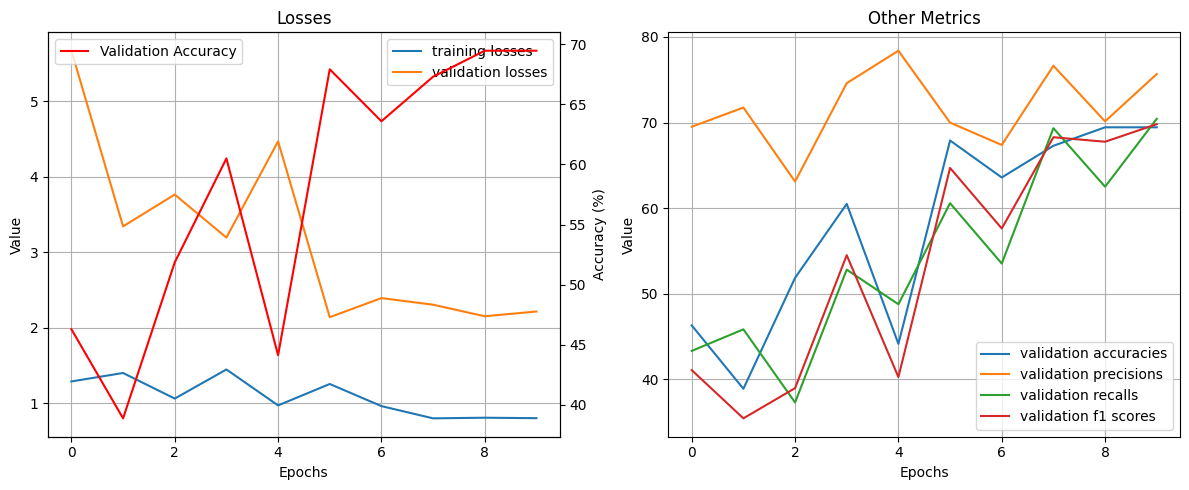

In [21]:
# step 4: plot the results
def visualize(metrics):
    cpu_metrics = {'training losses': [],
                   'validation losses': [],
                   'validation accuracies': [],
                   'validation precisions': [],
                   'validation recalls': [],
                   'validation f1 scores': []}

    for key, values in metrics.items():
        cpu_metrics[key] = [val.cpu().item() if hasattr(val, 'cpu') else val for val in values]

    losses = ['training losses', 'validation losses']
    other_metrics = ['validation accuracies', 'validation precisions', 'validation recalls', 'validation f1 scores']

    # Create figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot for losses
    axs[0].set_title('Losses')
    for metric in losses:
        axs[0].plot(cpu_metrics[metric], label=metric)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = axs[0].twinx()
    ax2.plot(cpu_metrics['validation accuracies'], 'r-', label='Validation Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper left')

    # Plot for other metrics
    axs[1].set_title('Other Metrics')
    for metric in other_metrics:
        axs[1].plot(cpu_metrics[metric], label=metric)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

visualize(metrics)


## AMMENITIES


In [29]:
import os
import shutil
import pandas as pd

# Base directory where the subdirectories are located
base_dir = 'D:\\School2(M)\\DSAIE\\STREET\\London_UK\\imagedb'

# Destination directory to save images into subfolders
destination_dir = 'D:\\School2(M)\\DSAIE\\STREET\\Models\\classified_data'

# Read the Excel file
excel_file = 'Image classification.xlsx'
df = pd.read_excel(excel_file)

# Create a dictionary to hold categories and their corresponding image lists
categories = {}

# Extract the relevant columns and their values
for index, row in df.iterrows():
    for category in ['f', 's_a', 's_b', 'b']:
        if pd.notna(row[category]):
            if row[category] not in categories:
                categories[row[category]] = []
            categories[row[category]].append(f"{row['Panoid']}_{category}")

# Create DataFrames and copy images to respective subfolders
for category, filenames in categories.items():
    # Construct the full path for each image
    image_paths = [os.path.join(base_dir, f"image_{filename}.png") for filename in filenames]
    
    # Create the subfolder if it doesn't exist
    category_path = os.path.join(destination_dir, category.strip())
    os.makedirs(category_path, exist_ok=True)
    
    # Copy each image to the corresponding subfolder
    for image_path, filename in zip(image_paths, filenames):
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")

    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")

Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Bridge
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\bridge
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Education and Learning Spaces
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Transportation and Mobility
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Financial and Administrative Services
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Entertainment and Cultural Spaces
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Retail and Commercial Services
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Public Amenities
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Food and Beverage
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Public and Government Buildings
Images copied to D:\School2(M)\DSAIE\STREET\Models\classified_data\Transportation and Mo

In [36]:
# Example: Calculate mean and std for dataset
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

data_dir = 'D:\School2(M)\DSAIE\STREET\Models/classified_data'
dataset = ImageFolder(root=data_dir, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean_ammenities = torch.tensor([0.0, 0.0, 0.0])
std_ammenities = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:
    # Compute mean and std per batch
    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean_ammenities += batch_mean
    std_ammenities += batch_std
mean_ammenities /= len(loader)
std_ammenities /= len(loader)

print(f"Dataset Mean: {mean}, Dataset Std: {std}")


Dataset Mean: tensor([0.4192, 0.4165, 0.4113]), Dataset Std: tensor([0.2137, 0.2126, 0.2191])


In [42]:
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F


# step 1: Load and transform the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduce image size, 224x224 is a common format for benchmarking CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_ammenities, std=std_ammenities)
])

train_dataset = ImageFolder(root=data_dir, transform=transform)

## split the data into training set and validation set
num_train = int(0.7 * len(train_dataset))
num_test = len(train_dataset) - num_train
train_data, val_data = random_split(train_dataset, [num_train, num_test])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)


# step 2: define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes)) # Replace the final layer with a new one adjusted for the number of classes in our dataset
model.to(device)
summary(model, input_size=(3, 224, 224))  
## the last layer of original resnet output is 1000x1 vector, but now we only have 3 features
## for the final vector, each element represents the score for each classification"


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [43]:
# Load the ResNet-34 model
resnet34 = models.resnet34(pretrained=True) # This ensures we load the pretrained weights

# We need to know the number of features in the last layer of the pretrained model to adapt our classifier.
# These are equal to the number of inputs of the "fully connected" (fc) head of the ResNet-34.
num_ftrs = resnet34.fc.in_features

# Modify the fully connected layer to match the number of classes for the land use identification case study
num_classes = 15
resnet34.fc = nn.Linear(num_ftrs, num_classes)
num_outputs = resnet34.fc.out_features
print(f"The modified ResNet-18 predicts {num_outputs} classes")

# Freeze all the layers
for param in resnet34.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in resnet34.fc.parameters():
    param.requires_grad = True

# Check that only the last two layers are not frozen (hidden and output layer of the classifier)
for param in resnet34.parameters():
    print(param.requires_grad)


The modified ResNet-18 predicts 15 classes
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [44]:
metrics = train(resnet34, train_loader, path='D:\School2(M)\DSAIE\STREET\Models/best_model_ammenities.pth')
# Load the best model after training is complete
resnet34.load_state_dict(torch.load('D:\School2(M)\DSAIE\STREET/Models/best_model_ammenities.pth'))
print("Loaded best model from:", 'D:\School2(M)\DSAIE\STREET\Models/best_model_ammenities.pth')
print(metrics)


Epoch 1: Improved validation accuracy to 22.10%. Model saved.
Epoch 1/10 Train Loss: 2.9819, Validation Loss: 6.1011, Accuracy: 22.10%
Epoch 2: Improved validation accuracy to 38.41%. Model saved.
Epoch 2/10 Train Loss: 2.2361, Validation Loss: 5.1269, Accuracy: 38.41%
Epoch 3: Improved validation accuracy to 39.86%. Model saved.
Epoch 3/10 Train Loss: 2.0121, Validation Loss: 4.2927, Accuracy: 39.86%
Epoch 4: Improved validation accuracy to 47.10%. Model saved.
Epoch 4/10 Train Loss: 1.6211, Validation Loss: 3.6860, Accuracy: 47.10%
Epoch 5: Improved validation accuracy to 49.64%. Model saved.
Epoch 5/10 Train Loss: 1.4164, Validation Loss: 3.3075, Accuracy: 49.64%
Epoch 6: Improved validation accuracy to 60.87%. Model saved.
Epoch 6/10 Train Loss: 1.2420, Validation Loss: 2.6415, Accuracy: 60.87%
Epoch 7: Improved validation accuracy to 71.01%. Model saved.
Epoch 7/10 Train Loss: 1.1381, Validation Loss: 2.5880, Accuracy: 71.01%
Epoch 8: Improved validation accuracy to 76.81%. Model 

C:\Users\lucia\AppData\Local\Temp\ipykernel_20296\2340763960.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('D:\School2(M)\DSAIE\STR

Loaded best model from: D:\School2(M)\DSAIE\STREET\Models/best_model_ammenities.pth
{'training losses': [2.9818846225738525, 2.2361283779144285, 2.012060308456421, 1.6211350202560424, 1.416408371925354, 1.2420425891876221, 1.1381160497665406, 0.9915933966636657, 0.9063281536102294, 0.9055918455123901], 'validation losses': [6.1011189222335815, 5.126920521259308, 4.292730748653412, 3.686021089553833, 3.30745005607605, 2.641544133424759, 2.5880253612995148, 2.0760586857795715, 1.978083223104477, 1.888927847146988], 'validation accuracies': [22.10144927536232, 38.405797101449274, 39.85507246376812, 47.10144927536232, 49.63768115942029, 60.86956521739131, 71.01449275362319, 76.81159420289855, 77.53623188405797, 76.81159420289855], 'validation precisions': [55.330064183913954, 63.68080788289001, 69.95024567488336, 74.44698703279938, 71.62536378673504, 75.0205885272048, 77.22515479503058, 80.28964443096339, 81.47297239709474, 80.8943673359078], 'validation recalls': [10.498742600488473, 12.0